# Preparación de ambiente

## Librerías

In [102]:
#from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge

pd.set_option('display.float_format', '{:.8f}'.format)

## Functions

In [103]:
# Catálogos y función para ingeniería de categóricas

category = [
    'Книги', 'Подарки', 'Игры', 'Игровые консоли', 'Аксессуары', 'Музыка', 
    'Программы', 'Кино', 'Карты оплаты', 'Служебные', #'Элементы питания', 
    'Чистые носители', #'Доставка товара', 'Билеты'
    ]

platform = [
    'PC', 'PS4', 'PS3', 'PSP', 'PSVita', 'XBOX', 'Blu-Ray', 'DVD', 'CD', 
    'MP3', 'Android', 'PSN', 'PS2', 'MAC', 'Windows', 'Live!', '1С'
    ]

content = [
    'Цифра', 'Коллекционное', 'Стандартные', 'Дополнительные', '3D', 
    'Аудиокниги'
    ]

def extract_string(text, str_list):
    for s in str_list:
        if s in text:
            return s
    return 'OTHER'

In [104]:
# Generar dummies
def generate_dummies(df, col_name):
    dummies = pd.get_dummies(df[col_name], prefix = col_name, dtype = 'int')
    df = pd.concat([df, dummies], axis = 1)
    return df

# Carga de datos

In [105]:
sales = pd.read_csv('data/sales_train.csv')
sales

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00000000,1.00000000
1,03.01.2013,0,25,2552,899.00000000,1.00000000
2,05.01.2013,0,25,2552,899.00000000,-1.00000000
3,06.01.2013,0,25,2554,1709.05000000,1.00000000
4,15.01.2013,0,25,2555,1099.00000000,1.00000000
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00000000,1.00000000
2935845,09.10.2015,33,25,7460,299.00000000,1.00000000
2935846,14.10.2015,33,25,7459,349.00000000,1.00000000
2935847,22.10.2015,33,25,7440,299.00000000,1.00000000


In [106]:
items = pd.read_csv('data/items.csv')
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [107]:
categories = pd.read_csv('data/item_categories.csv')
categories

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


In [108]:
shops = pd.read_csv('data/shops.csv')
shops

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [109]:
print('sales:', sales.shape)
print('items:', items.shape)
print('shops:', shops.shape)
print('categories :', categories.shape)

sales: (2935849, 6)
items: (22170, 3)
shops: (60, 2)
categories : (84, 2)


Queremos integrar toda la información en un único dataset, pero antes tenemos que hacer algunas validaciones. 
- Primero verificamos que los id's de los catálogos 'items', 'categories' y 'shops' sean únicos:

In [110]:
items['item_id'].value_counts().max(), categories['item_category_id'].value_counts().max(), shops['shop_id'].value_counts().max()

(np.int64(1), np.int64(1), np.int64(1))

- Ahora verificamos que a cada 'item_id' le corresponda un único 'item_category_id':

In [111]:
item_cat_check = items[['item_id', 'item_category_id']].drop_duplicates()
item_cat_check = item_cat_check.groupby('item_id').agg(
    n_categories = ('item_category_id', 'nunique'), 
    categories = ('item_category_id', lambda x: sorted(x.unique()))
    )
item_cat_check.reset_index(inplace = True)
item_cat_check

,item_id,n_categories,categories
0,0,1,[40]
1,1,1,[76]
2,2,1,[40]
3,3,1,[40]
4,4,1,[40]
...,...,...,...
22165,22165,1,[31]
22166,22166,1,[54]
22167,22167,1,[49]
22168,22168,1,[62]


In [112]:
item_cat_check['n_categories'].value_counts()

n_categories
1    22170
Name: count, dtype: int64

Hecho esto podemos unir los datasets:

In [113]:
data = pd.merge(sales, items, how = 'left', on = 'item_id')
data = pd.merge(data, categories, how = 'left', on = 'item_category_id')
data = pd.merge(data, shops, how = 'left', on = 'shop_id')
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,02.01.2013,0,59,22154,999.00000000,1.00000000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,03.01.2013,0,25,2552,899.00000000,1.00000000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,05.01.2013,0,25,2552,899.00000000,-1.00000000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,06.01.2013,0,25,2554,1709.05000000,1.00000000,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,15.01.2013,0,25,2555,1099.00000000,1.00000000,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00000000,1.00000000,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935845,09.10.2015,33,25,7460,299.00000000,1.00000000,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935846,14.10.2015,33,25,7459,349.00000000,1.00000000,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935847,22.10.2015,33,25,7440,299.00000000,1.00000000,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


# Data cleaning

### Variables, data type and duplicates

Agrupamos los tipos de variable y revisamos que tengan el tipo de dato correcto:

In [114]:
ids = ['date', 'shop_id', 'item_id', 'item_category_id']
cat = ['item_name', 'item_category_name', 'shop_name']
num = ['date_block_num', 'item_price', 'item_cnt_day']

In [115]:
data.info()

<class 'pandas.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   date                str    
 1   date_block_num      int64  
 2   shop_id             int64  
 3   item_id             int64  
 4   item_price          float64
 5   item_cnt_day        float64
 6   item_name           str    
 7   item_category_id    int64  
 8   item_category_name  str    
 9   shop_name           str    
dtypes: float64(2), int64(4), str(4)
memory usage: 634.4 MB


Cambiamos las fechas al tipo correcto:

In [116]:
data['date'] = pd.to_datetime(data['date'], format = '%d.%m.%Y')

Revisamos si hay registros duplicados:

In [117]:
data[data.duplicated(keep = False)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
76961,2013-01-05,0,54,20130,149.00000000,1.00000000,УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD,"Химки ТЦ ""Мега"""
76962,2013-01-05,0,54,20130,149.00000000,1.00000000,УЧЕНИК ЧАРОДЕЯ (регион),40,Кино - DVD,"Химки ТЦ ""Мега"""
1435365,2014-02-23,13,50,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Тюмень ТЦ ""Гудвин"""
1435367,2014-02-23,13,50,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Тюмень ТЦ ""Гудвин"""
1496765,2014-03-23,14,21,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Москва МТРЦ ""Афи Молл"""
1496766,2014-03-23,14,21,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Москва МТРЦ ""Афи Молл"""
1671872,2014-05-01,16,50,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Тюмень ТЦ ""Гудвин"""
1671873,2014-05-01,16,50,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Тюмень ТЦ ""Гудвин"""
1866322,2014-07-12,18,25,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Москва ТРК ""Атриум"""
1866340,2014-07-12,18,25,3423,999.00000000,1.00000000,"Far Cry 3 (Classics) [Xbox 360, русская версия]",23,Игры - XBOX 360,"Москва ТРК ""Атриум"""


Sí los hay, procedemos a eliminarlos:

In [118]:
data.drop_duplicates(inplace = True)
data.reset_index(drop = True, inplace = True)
data

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00000000,1.00000000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00000000,1.00000000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00000000,-1.00000000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05000000,1.00000000,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00000000,1.00000000,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2935838,2015-10-10,33,25,7409,299.00000000,1.00000000,V/A Nu Jazz Selection (digipack),55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935839,2015-10-09,33,25,7460,299.00000000,1.00000000,V/A The Golden Jazz Collection 1 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935840,2015-10-14,33,25,7459,349.00000000,1.00000000,V/A The Best Of The 3 Tenors,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2935841,2015-10-22,33,25,7440,299.00000000,1.00000000,V/A Relax Collection Planet MP3 (mp3-CD) (jewel),57,Музыка - MP3,"Москва ТРК ""Атриум"""


### Numerical and id variables

Ahora hacemos una revisión general por tipo de variable comenzando con la fecha, id's y numéricas:

In [119]:
data[ids + num].describe([x/4 for x in range(1, 4)] + [x/100 for x in range(95, 101)])

,date,shop_id,item_id,item_category_id,date_block_num,item_price,item_cnt_day
count,2935843,2935843.00000000,2935843.00000000,2935843.00000000,2935843.00000000,2935843.00000000,2935843.00000000
mean,2014-04-03 05:44:38.044159,33.00171331,10197.22901293,40.00140709,14.56991263,890.85347151,1.24264138
min,2013-01-01 00:00:00,0.00000000,0.00000000,0.00000000,0.00000000,-1.00000000,-22.00000000
25%,2013-08-01 00:00:00,22.00000000,4476.00000000,28.00000000,7.00000000,249.00000000,1.00000000
50%,2014-03-04 00:00:00,31.00000000,9343.00000000,40.00000000,14.00000000,399.00000000,1.00000000
75%,2014-12-05 00:00:00,47.00000000,15684.00000000,55.00000000,23.00000000,999.00000000,1.00000000
95%,2015-08-09 00:00:00,57.00000000,20949.00000000,71.00000000,31.00000000,2690.00000000,2.00000000
96%,2015-08-25 00:00:00,57.00000000,21271.00000000,72.00000000,31.00000000,2999.00000000,2.00000000
97%,2015-09-10 00:00:00,58.00000000,21440.00000000,72.00000000,32.00000000,3190.00000000,3.00000000
98%,2015-09-27 00:00:00,58.00000000,21695.00000000,75.00000000,32.00000000,3590.00000000,3.00000000


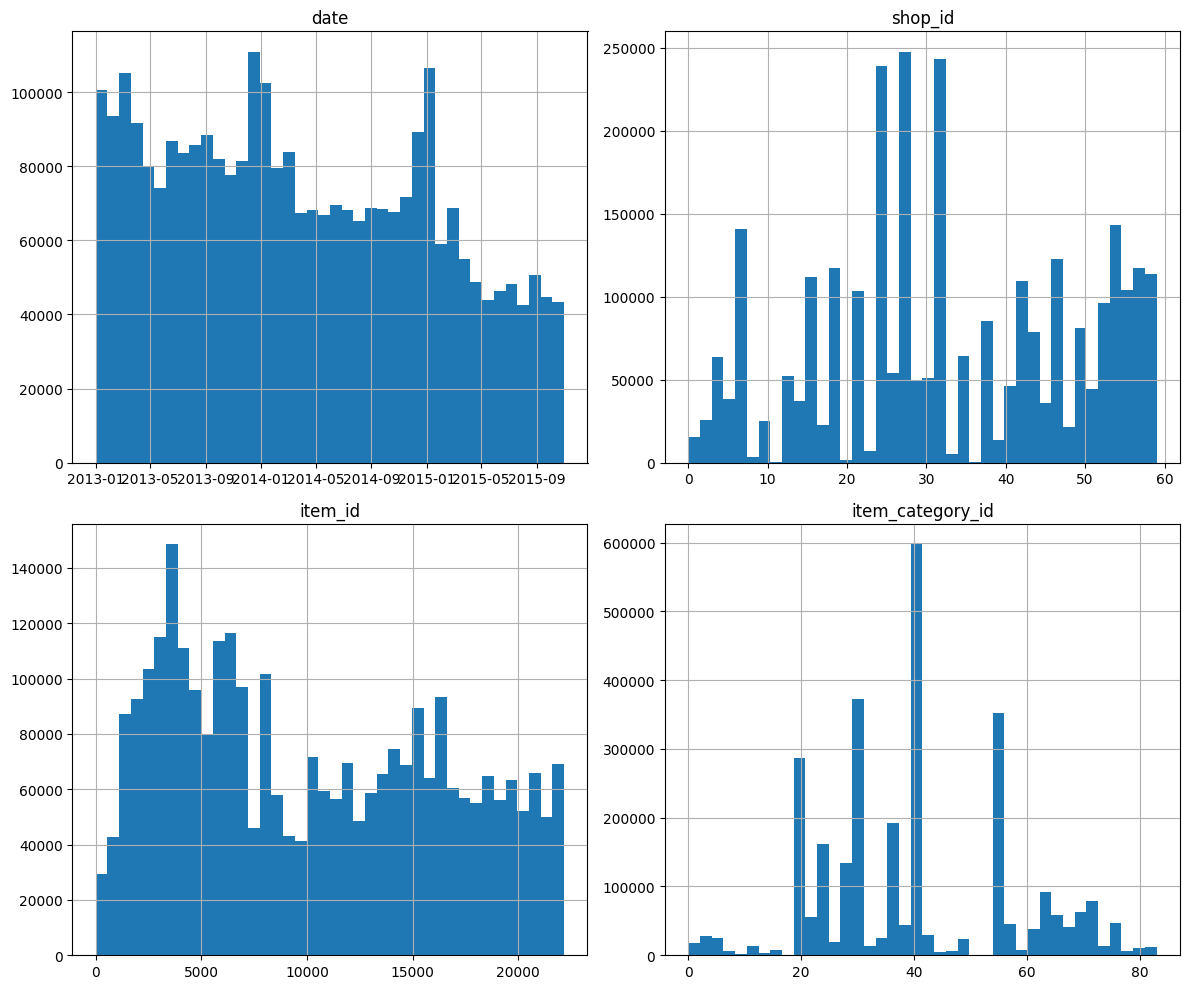

In [120]:
data[ids].hist(bins = 40, figsize = (12, 10))
plt.tight_layout()
plt.show()

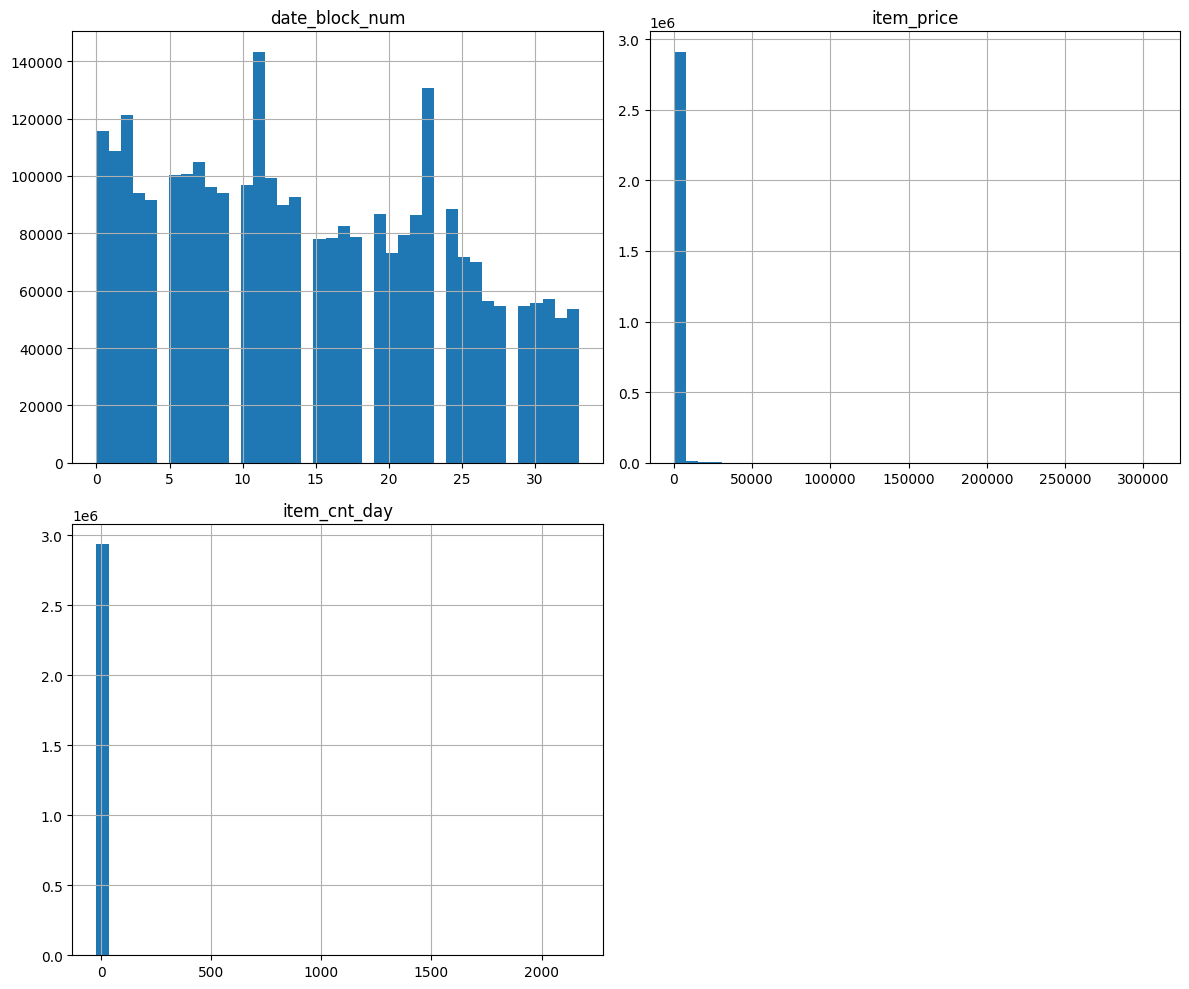

In [121]:
data[num].hist(bins = 40, figsize=(12, 10))
plt.tight_layout()
plt.show()

In [122]:
data[ids + num].isna().sum()

date                0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
item_price          0
item_cnt_day        0
dtype: int64

In [123]:
data[ids + num].isnull().sum()

date                0
shop_id             0
item_id             0
item_category_id    0
date_block_num      0
item_price          0
item_cnt_day        0
dtype: int64

Observamos lo siguiente:

- No detectamos valores faltantes registrados como tales (NAN o NULL). Todavía es preciso revisar con mayor detalle.
- Las fechas se encuentran en el rango esperado y al hacer la conversión no detectamos problemas de tipo de dato. 
- Las variables identificadoras tienen valores razonables en su mayoría, aunque hay que revisar si el valor 0 es aceptable en todos los caos. 
- También es necesario profundizar en las variables '´¨'item_price' e 'item_cnt_day' que tienen valores negativos y al parecer algunos outliers.

### Zero values

Comenzamos viendo los identificadores que tienen valor 0:

In [124]:
data[data['shop_id'] == 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
37589,2013-01-12,0,0,11059,73.00000000,1.00000000,ДИВЕРСАНТ:КОНЕЦ ВОЙНЫ (регион),40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
37590,2013-01-22,0,0,11059,73.00000000,1.00000000,ДИВЕРСАНТ:КОНЕЦ ВОЙНЫ (регион),40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
37591,2013-01-26,0,0,11059,73.00000000,1.00000000,ДИВЕРСАНТ:КОНЕЦ ВОЙНЫ (регион),40,Кино - DVD,"!Якутск Орджоникидзе, 56 фран"
37592,2013-01-12,0,0,11347,170.00000000,1.00000000,Дидюля Grand Collection (mp3-CD) (Jewel),57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"
37593,2013-01-22,0,0,11347,170.00000000,1.00000000,Дидюля Grand Collection (mp3-CD) (Jewel),57,Музыка - MP3,"!Якутск Орджоникидзе, 56 фран"
...,...,...,...,...,...,...,...,...,...,...
183256,2013-02-22,1,0,13460,1228.00000000,2.00000000,"Комплект «Invizimals: Затерянные племена [PSP,...",21,Игры - PSP,"!Якутск Орджоникидзе, 56 фран"
183257,2013-02-21,1,0,13460,1228.00000000,1.00000000,"Комплект «Invizimals: Затерянные племена [PSP,...",21,Игры - PSP,"!Якутск Орджоникидзе, 56 фран"
183258,2013-02-20,1,0,13460,1228.00000000,1.00000000,"Комплект «Invizimals: Затерянные племена [PSP,...",21,Игры - PSP,"!Якутск Орджоникидзе, 56 фран"
183259,2013-02-17,1,0,13460,1228.00000000,1.00000000,"Комплект «Invizimals: Затерянные племена [PSP,...",21,Игры - PSP,"!Якутск Орджоникидзе, 56 фран"


In [125]:
data[data['item_id'] == 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1972631,2014-09-01,20,54,0,58.00000000,1.00000000,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,Кино - DVD,"Химки ТЦ ""Мега"""


In [126]:
data[data['item_category_id'] == 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
5558,2013-01-10,0,25,16257,148.00000000,1.00000000,Наушники RITMIX RH-124 Black,0,PC - Гарнитуры/Наушники,"Москва ТРК ""Атриум"""
182615,2013-02-28,1,0,16255,93.00000000,1.00000000,Наушники PHILIPS SBC HC8680,0,PC - Гарнитуры/Наушники,"!Якутск Орджоникидзе, 56 фран"
439376,2013-04-02,3,38,16256,22.40000000,1.00000000,Наушники RITMIX RH-120,0,PC - Гарнитуры/Наушники,"Омск ТЦ ""Мега"""


El valor 0 en la variable 'shop_id' parece ser válido, pero en las variables 'item_id' 'item_category_id' sólo se tienen unos pocos casos aislados. Vamos a revisar si podemos identificar otro valor a partir de su 'item_name' o del 'item_category_name'. Si no es así, se verificará si es un caso único o hay otros casos con tan pocas variables:

In [127]:
a = data[data['item_id'] == 0]['item_name'].unique()[0]
data[data['item_name'] == a]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1972631,2014-09-01,20,54,0,58.00000000,1.00000000,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40,Кино - DVD,"Химки ТЦ ""Мега"""


In [128]:
a = data[data['item_category_id'] == 0]['item_category_name'].unique()[0]
data[data['item_category_name'] == a]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
5558,2013-01-10,0,25,16257,148.00000000,1.00000000,Наушники RITMIX RH-124 Black,0,PC - Гарнитуры/Наушники,"Москва ТРК ""Атриум"""
182615,2013-02-28,1,0,16255,93.00000000,1.00000000,Наушники PHILIPS SBC HC8680,0,PC - Гарнитуры/Наушники,"!Якутск Орджоникидзе, 56 фран"
439376,2013-04-02,3,38,16256,22.40000000,1.00000000,Наушники RITMIX RH-120,0,PC - Гарнитуры/Наушники,"Омск ТЦ ""Мега"""


Podríamos eliminar estos registros, pero como no encontramos evidencia de que puedan estar mal etiquetados de momento los aceptaremos como registros válidos.

### Variable 'item_price'

Continuamos observando más de cerca los posibles outliers en la variable 'item_price':

In [129]:
data[data['item_price'] > 50000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
885137,2013-09-17,8,12,11365,59200.00000000,1.00000000,Доставка (EMS),9,Доставка товара,Интернет-магазин ЧС
1163157,2013-12-13,11,12,6066,307980.00000000,1.00000000,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,Интернет-магазин ЧС
1488133,2014-03-20,14,25,13199,50999.00000000,1.00000000,Коллекционные шахматы (Властелин Колец),69,Подарки - Сувениры,"Москва ТРК ""Атриум"""


In [130]:
data[data['item_id'] == 6066]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1163157,2013-12-13,11,12,6066,307980.00000000,1.00000000,Radmin 3 - 522 лиц.,75,Программы - Для дома и офиса,Интернет-магазин ЧС


In [131]:
data[data['item_category_id'] == 75].describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,42603,42603.00000000,42603.00000000,42603.00000000,42603.00000000,42603.00000000,42603.00000000
mean,2014-02-10 23:16:38.042391,12.88843509,30.51404831,4831.71675704,1859.86707347,1.13193907,75.00000000
min,2013-01-01 00:00:00,0.00000000,0.00000000,830.00000000,91.00000000,-2.00000000,75.00000000
25%,2013-06-08 00:00:00,5.00000000,21.00000000,4128.00000000,1049.00000000,1.00000000,75.00000000
50%,2013-12-30 00:00:00,11.00000000,27.00000000,4178.00000000,1490.00000000,1.00000000,75.00000000
75%,2014-10-01 00:00:00,21.00000000,44.00000000,5068.00000000,1990.00000000,1.00000000,75.00000000
max,2015-10-31 00:00:00,33.00000000,59.00000000,21977.00000000,307980.00000000,110.00000000,75.00000000
std,NaN,9.33791094,16.13434772,2326.80000819,2154.25541878,0.81528878,0.00000000


Revisando el valor más alto de la variable 'item_price', buscamos si hay otros registros que tengan el mismo 'item_id' pero es el único registro, luego buscamos cómo es el comportamiento de los datos en esa categoría y vemos que los precios no son altos lo que nos da más indicios de que es un valor equivocado. Lo que hacemos es usar un fragmento del 'item_name' para buscar otros productos similares:

In [132]:
data[data['item_name'].str.contains('Radmin 3')]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
291237,2013-03-21,2,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
291259,2013-03-22,2,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
318707,2013-03-11,2,25,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Москва ТРК ""Атриум"""
370176,2013-04-18,3,12,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Интернет-магазин ЧС
375066,2013-04-06,3,6,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Воронеж (Плехановская, 13)"
379229,2013-04-12,3,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
379231,2013-04-20,3,22,6065,1299.00000000,2.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
487025,2013-05-05,4,54,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Химки ТЦ ""Мега"""
542237,2013-06-07,5,29,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Москва ТЦ ""Новый век"" (Новокосино)"
679922,2013-07-29,6,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21


En efecto, encontramos registros muy similares, por lo que imputaremos no sólo el precio, sino también el id y el nombre del producto pues todos los otros son consistentes:

In [133]:
data.iloc[1163157, 3] = 6065
data.iloc[1163157, 4] = 1299
data.iloc[1163157, 6] = 'Radmin 3  - 1 лиц.'

In [134]:
data[data['item_name'] == 'Radmin 3  - 1 лиц.']

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
291237,2013-03-21,2,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
291259,2013-03-22,2,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
318707,2013-03-11,2,25,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Москва ТРК ""Атриум"""
370176,2013-04-18,3,12,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Интернет-магазин ЧС
375066,2013-04-06,3,6,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Воронеж (Плехановская, 13)"
379229,2013-04-12,3,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
379231,2013-04-20,3,22,6065,1299.00000000,2.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21
487025,2013-05-05,4,54,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Химки ТЦ ""Мега"""
542237,2013-06-07,5,29,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,"Москва ТЦ ""Новый век"" (Новокосино)"
679922,2013-07-29,6,22,6065,1299.00000000,1.00000000,Radmin 3 - 1 лиц.,75,Программы - Для дома и офиса,Москва Магазин С21


Ahora revisamos los valores pequeños o negativos:

In [135]:
data[data['item_price'] < 0.1]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
484682,2013-05-15,4,32,2973,-1.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
579765,2013-06-11,5,6,11864,0.07000000,1.00000000,Змей ДЖЕККИ с сердечком 36 см,63,Подарки - Мягкие игрушки,"Воронеж (Плехановская, 13)"
608762,2013-06-08,5,58,11865,0.07000000,1.00000000,Змей МАКС антистресс 33 см.,63,Подарки - Мягкие игрушки,"Якутск ТЦ ""Центральный"""
611399,2013-06-08,5,58,20146,0.08750000,4.00000000,Удавчик Плюшевый: 75см. (яйцо ткань),63,Подарки - Мягкие игрушки,"Якутск ТЦ ""Центральный"""
673154,2013-07-31,6,6,11872,0.09000000,1.00000000,Змея ВАСИЛИСА 23 см,63,Подарки - Мягкие игрушки,"Воронеж (Плехановская, 13)"


In [136]:
data[(data['item_id'] == 2973) & (data['shop_id'] == 32) & (data['date'] < '2013-08-15')]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
67427,2013-01-29,0,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
67428,2013-01-25,0,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
67429,2013-01-22,0,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
67430,2013-01-21,0,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
67431,2013-01-18,0,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
67432,2013-01-17,0,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
67433,2013-01-15,0,32,2973,2499.00000000,3.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
187843,2013-02-05,1,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
187844,2013-02-14,1,32,2973,2499.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""
484681,2013-05-23,4,32,2973,1249.00000000,1.00000000,"DmC Devil May Cry [PS3, русские субтитры]",19,Игры - PS3,"Москва ТЦ ""Серебряный Дом"""


In [137]:
data[(data['item_id'] == 2973) & (data['shop_id'] == 32) & (data['date'] < '2013-08-15')].describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,13,13.00000000,13.00000000,13.00000000,13.00000000,13.00000000,13.00000000
mean,2013-03-01 14:46:09.230769,1.46153846,32.00000000,2973.00000000,2114.42307692,1.15384615,19.00000000
min,2013-01-15 00:00:00,0.00000000,32.00000000,2973.00000000,-1.00000000,1.00000000,19.00000000
25%,2013-01-21 00:00:00,0.00000000,32.00000000,2973.00000000,2499.00000000,1.00000000,19.00000000
50%,2013-01-29 00:00:00,0.00000000,32.00000000,2973.00000000,2499.00000000,1.00000000,19.00000000
75%,2013-05-06 00:00:00,4.00000000,32.00000000,2973.00000000,2499.00000000,1.00000000,19.00000000
max,2013-06-05 00:00:00,5.00000000,32.00000000,2973.00000000,2499.00000000,3.00000000,19.00000000
std,NaN,1.98390963,0.00000000,0.00000000,787.98571915,0.55470020,0.00000000


Revisando el precio del item en la misma tienda en fechas cercanas al registro donde vemos este valor negativo, encontramos que los otros registros tienen otro valor de forma consistente, por lo que usaremos la mediana para imputar:

In [138]:
data.iloc[484682, 4] = 2499

In [139]:
data[(data['item_id'] == 2973) & (data['shop_id'] == 32) & (data['date'] < '2013-08-15')].describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,13,13.00000000,13.00000000,13.00000000,13.00000000,13.00000000,13.00000000
mean,2013-03-01 14:46:09.230769,1.46153846,32.00000000,2973.00000000,2306.73076923,1.15384615,19.00000000
min,2013-01-15 00:00:00,0.00000000,32.00000000,2973.00000000,1249.00000000,1.00000000,19.00000000
25%,2013-01-21 00:00:00,0.00000000,32.00000000,2973.00000000,2499.00000000,1.00000000,19.00000000
50%,2013-01-29 00:00:00,0.00000000,32.00000000,2973.00000000,2499.00000000,1.00000000,19.00000000
75%,2013-05-06 00:00:00,4.00000000,32.00000000,2973.00000000,2499.00000000,1.00000000,19.00000000
max,2013-06-05 00:00:00,5.00000000,32.00000000,2973.00000000,2499.00000000,3.00000000,19.00000000
std,NaN,1.98390963,0.00000000,0.00000000,469.32338777,0.55470020,0.00000000


In [140]:
data.describe([x/4 for x in range(1, 4)] + [x/100 for x in range(95, 101)])

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935843,2935843.00000000,2935843.00000000,2935843.00000000,2935843.00000000,2935843.00000000,2935843.00000000
mean,2014-04-03 05:44:38.044159,14.56991263,33.00171331,10197.22901259,890.74986209,1.24264138,40.00140709
min,2013-01-01 00:00:00,0.00000000,0.00000000,0.00000000,0.07000000,-22.00000000,0.00000000
25%,2013-08-01 00:00:00,7.00000000,22.00000000,4476.00000000,249.00000000,1.00000000,28.00000000
50%,2014-03-04 00:00:00,14.00000000,31.00000000,9343.00000000,399.00000000,1.00000000,40.00000000
75%,2014-12-05 00:00:00,23.00000000,47.00000000,15684.00000000,999.00000000,1.00000000,55.00000000
95%,2015-08-09 00:00:00,31.00000000,57.00000000,20949.00000000,2690.00000000,2.00000000,71.00000000
96%,2015-08-25 00:00:00,31.00000000,57.00000000,21271.00000000,2999.00000000,2.00000000,72.00000000
97%,2015-09-10 00:00:00,32.00000000,58.00000000,21440.00000000,3190.00000000,3.00000000,72.00000000
98%,2015-09-27 00:00:00,32.00000000,58.00000000,21695.00000000,3590.00000000,3.00000000,75.00000000


In [141]:
data[data['item_price'] > 42000]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
885137,2013-09-17,8,12,11365,59200.00000000,1.00000000,Доставка (EMS),9,Доставка товара,Интернет-магазин ЧС
1488133,2014-03-20,14,25,13199,50999.00000000,1.00000000,Коллекционные шахматы (Властелин Колец),69,Подарки - Сувениры,"Москва ТРК ""Атриум"""
2327153,2015-01-29,24,12,7241,49782.00000000,1.00000000,UserGate Proxy & Firewall 6.X с модулем фильтр...,75,Программы - Для дома и офиса,Интернет-магазин ЧС
2885686,2015-10-23,33,42,13403,42990.00000000,1.00000000,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16,Игровые консоли - XBOX ONE,"СПб ТК ""Невский Центр"""
2910150,2015-10-29,33,12,13403,42990.00000000,1.00000000,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16,Игровые консоли - XBOX ONE,Интернет-магазин ЧС
2917754,2015-10-20,33,3,13403,42990.00000000,1.00000000,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16,Игровые консоли - XBOX ONE,"Балашиха ТРК ""Октябрь-Киномир"""
2931374,2015-10-20,33,22,13403,42990.00000000,1.00000000,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",16,Игровые консоли - XBOX ONE,Москва Магазин С21


### Variable 'item_cnt_day'

Continuamos observando más de cerca los posibles outliers en la variable 'item_cnt_day':

In [142]:
data[data['item_cnt_day'] > 600]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2326924,2015-01-15,24,12,20949,4.00000000,1000.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",Интернет-магазин ЧС
2608034,2015-04-14,27,12,3731,1904.54807692,624.00000000,"Grand Theft Auto V [PC, русские субтитры]",30,Игры PC - Стандартные издания,Интернет-магазин ЧС
2851085,2015-09-30,32,55,9249,1702.82574568,637.00000000,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) У...",8,Билеты (Цифра),Цифровой склад 1С-Онлайн
2864229,2015-09-30,32,12,9248,1692.52615845,669.00000000,"Билет ""ИгроМир 2015"" - 3 октября 2015 (сайт) [...",80,Служебные - Билеты,Интернет-магазин ЧС
2909812,2015-10-28,33,12,11373,0.90871369,2169.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС


Vemos otros registros con los mismos 'item_id' para ver si son valores muy distintos a los habituales para ese producto:

In [143]:
data[data['item_id'] == 11373].describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,464,464.00000000,464.00000000,464.00000000,464.00000000,464.00000000,464.00000000
mean,2014-09-13 18:31:02.068965,19.94827586,12.00000000,11373.00000000,367.54890922,14.14439655,9.00000000
min,2013-01-08 00:00:00,0.00000000,12.00000000,11373.00000000,0.90871369,1.00000000,9.00000000
25%,2014-02-19 06:00:00,13.00000000,12.00000000,11373.00000000,184.61684783,2.00000000,9.00000000
50%,2014-10-12 00:00:00,21.00000000,12.00000000,11373.00000000,281.62500000,4.00000000,9.00000000
75%,2015-05-04 06:00:00,28.00000000,12.00000000,11373.00000000,443.08333333,8.00000000,9.00000000
max,2015-10-29 00:00:00,33.00000000,12.00000000,11373.00000000,2137.00000000,2169.00000000,9.00000000
std,NaN,8.81765834,0.00000000,0.00000000,296.95306149,104.60493740,0.00000000


In [144]:
data[(data['item_id'] == 11373) & (data['item_cnt_day'] > 15)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1006878,2013-10-29,9,12,11373,222.42857143,28.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1058339,2013-11-22,10,12,11373,102.46694215,242.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1058342,2013-11-29,10,12,11373,72.20000000,105.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1175227,2013-12-16,11,12,11373,115.72222222,18.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1398727,2014-02-20,13,12,11373,89.06896552,58.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1398729,2014-02-24,13,12,11373,134.65000000,20.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1398752,2014-02-08,13,12,11373,110.88888889,27.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1398773,2014-02-05,13,12,11373,105.95454546,22.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1398774,2014-02-06,13,12,11373,89.88888889,18.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС
1547378,2014-03-01,14,12,11373,119.18181818,22.00000000,Доставка до пункта выдачи (Boxberry),9,Доставка товара,Интернет-магазин ЧС


Encontramos que este es el único registro con este valor tan alto en cuanto a ventas diarias y además que tiene un precio excesivamente bajo. Podría tratarse de una liquidación, pero no tenemos certeza, en este caso decidimo que lo mejor sería eliminar el registro.

In [145]:
data = data[data['item_cnt_day'] < 2000].copy()

Revisamos el item que tiene el siguiente valor más grande:

In [146]:
data[data['item_id'] == 20949].describe()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,31340,31340.00000000,31340.00000000,31340.00000000,31340.00000000,31340.00000000,31340.00000000
mean,2014-07-06 21:55:37.179323,17.68334397,31.63283344,20949.00000000,4.91485570,5.98730057,71.00000000
min,2013-04-24 00:00:00,3.00000000,2.00000000,20949.00000000,1.83000000,-16.00000000,71.00000000
25%,2013-12-06 00:00:00,11.00000000,18.00000000,20949.00000000,5.00000000,2.00000000,71.00000000
50%,2014-06-30 00:00:00,17.00000000,30.00000000,20949.00000000,5.00000000,3.00000000,71.00000000
75%,2015-01-14 00:00:00,24.00000000,46.00000000,20949.00000000,5.00000000,7.00000000,71.00000000
max,2015-10-31 00:00:00,33.00000000,59.00000000,20949.00000000,5.00000000,1000.00000000,71.00000000
std,NaN,8.25571230,16.90770951,0.00000000,0.39804184,11.49765541,0.00000000


In [147]:
data[(data['item_id'] == 20949) & (data['item_cnt_day'] > 300)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
1501157,2014-03-15,14,24,20949,5.00000000,405.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Москва ТК ""Буденовский"" (пав.К7)"
1708203,2014-06-28,17,25,20949,5.00000000,501.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Москва ТРК ""Атриум"""
2137366,2014-11-11,22,54,20949,4.76038339,313.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши","Химки ТЦ ""Мега"""
2257293,2014-12-19,23,12,20949,4.00000000,500.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",Интернет-магазин ЧС
2326924,2015-01-15,24,12,20949,4.00000000,1000.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",Интернет-магазин ЧС
2909395,2015-10-14,33,12,20949,4.00000000,500.00000000,Фирменный пакет майка 1С Интерес белый (34*42)...,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",Интернет-магазин ЧС


En este caso el precio se encuentra alineado con lo que observamos en en ese tipo de productos, así que aunque tiene ventas altas, el valor parece legítimo, lo conservamos.

Finalmente revisamos los registros con conteos negativos:

In [148]:
data[data['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name
2,2013-01-05,0,25,2552,899.00000000,-1.00000000,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
148,2013-01-23,0,25,2321,999.00000000,-1.00000000,Call of Duty: Black Ops II. Расширенное издани...,28,Игры PC - Дополнительные издания,"Москва ТРК ""Атриум"""
175,2013-01-07,0,25,2199,1449.00000000,-1.00000000,COLDPLAY Mylo Xyloto LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
807,2013-01-02,0,25,2330,599.00000000,-1.00000000,"Call of Duty: Black Ops [PC, Jewel, русская ве...",30,Игры PC - Стандартные издания,"Москва ТРК ""Атриум"""
1041,2013-01-13,0,25,5034,1989.00000000,-1.00000000,"NHL 13 [Xbox 360, русская документация]",23,Игры - XBOX 360,"Москва ТРК ""Атриум"""
...,...,...,...,...,...,...,...,...,...,...
2934237,2015-10-26,33,25,3917,449.00000000,-1.00000000,IRON MAIDEN The Book Of Souls 2CD,55,Музыка - CD локального производства,"Москва ТРК ""Атриум"""
2934456,2015-10-18,33,25,4896,6398.00000000,-1.00000000,"Mortal Kombat X. Kollector's Edition [PS4, рус...",20,Игры - PS4,"Москва ТРК ""Атриум"""
2935257,2015-10-05,33,25,10039,249.00000000,-1.00000000,ВОССТАНИЕ ПЛАНЕТЫ ОБЕЗЬЯН (BD),37,Кино - Blu-Ray,"Москва ТРК ""Атриум"""
2935637,2015-10-16,33,25,7893,2990.00000000,-1.00000000,X360: Геймпад беспроводной черный - Wireless C...,6,Аксессуары - XBOX 360,"Москва ТРК ""Атриум"""


Estos valores negativos podríamos interpretarlos como devoluciones y no son poco frecuentes, por lo que los vamos a dejar. No queremos que nuestro modelo no haya visto este tipo de valores cuando llegue el momento de hacer la predicción.

### Categóricas

Ahora continuamos con las variables categóricas:

In [149]:
for c in cat:
    print(data[c].value_counts(), '\n\n')

item_name
Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм                                    31340
Playstation Store пополнение бумажника: Карта оплаты 1000 руб.                            9408
Прием денежных средств для 1С-Онлайн                                                      9067
Diablo III [PC, Jewel, русская версия]                                                    7479
Kaspersky Internet Security Multi-Device Russian Edition. 2-Device 1 year Renewal Box     6853
                                                                                         ...  
АХ, ВОДЕВИЛЬ, ВОДЕВИЛЬ (rem)                                                                 1
XBOX 360 S 250GB CONSOLE/KINECT BUNDLE KUNG FU PAL EN/RU RUSSIA                              1
WARHAMMER ACCESSORIES: Khorne Dice арт. 65-13                                                1
WARHAMMER MINIATURES: Dark Elf Doomfire Warlocks арт. 85-14                                  1
WARHAMMER MINIATURES: Stormcast Eternals

Podemos ver que las variables se encuentran muy pulverizadas, pero al parecer hay elementos dentro de cada una de ellas que pueden extraerse para generar grupos más grandes. Se explorará esta opción en la sección de Feature Engineering.

# Feature Engineering

Esta sección usualmente va después del EDA aunque en realidad el proceso de exploración y generación de variables (también el de limpieza) es un ir y venir entre cada etapa, pues se retroalimentan. Por practicidad, en esta ocasión colocamos la sección antes pues nos permite crear las variables que también usaremos para las visualizaciones del EDA.

Comenzamos cambiando la periodicidad de nuestros datos a mensual:

In [150]:
data = data.copy()
data['month'] = data['date'].dt.to_period('M')
data['price_log'] = np.log1p(data['item_price'])

monthly = (
    data
    .groupby([
        'month', 'date_block_num', 'shop_id', 'item_id', 'item_category_id'
        ], as_index = False)
    .agg(
        item_cnt_month = ('item_cnt_day', 'sum'),
        avg_price = ('item_price', 'mean'),
        avg_log_price = ('price_log', 'mean')
    )
)

monthly['item_cnt_month'] = monthly['item_cnt_month'].clip(0, 20)

monthly = monthly.sort_values(['shop_id', 'item_id', 'month']).reset_index(drop = True)
monthly['month_num'] = monthly['month'].dt.month
monthly['year'] = monthly['month'].dt.year
monthly['is_q4'] = monthly["month_num"].isin([10, 11, 12]).astype(int)

In [151]:
#monthly.describe([x/4 for x in range(1, 4)] + [x/100 for x in range(95, 101)])

In [152]:
monthly.describe([x/100 for x in range(0, 5)] + [x/4 for x in range(1, 4)] + [x/100 for x in range(95, 101)])

,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,avg_price,avg_log_price,month_num,year,is_q4
count,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000
mean,14.66479277,32.80584840,10680.99026738,41.54191784,2.02280247,790.69463435,6.07602519,6.15461207,2013.79251506,0.21625555
std,9.54232216,16.53700916,6238.88310209,16.32365167,2.57796176,1532.59134257,1.01524015,3.45523118,0.77733265,0.41169065
min,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.09000000,0.08609300,1.00000000,2013.00000000,0.00000000
0%,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.09000000,0.08609300,1.00000000,2013.00000000,0.00000000
1%,0.00000000,2.00000000,534.00000000,3.00000000,1.00000000,58.00000000,4.07753744,1.00000000,2013.00000000,0.00000000
2%,0.00000000,3.00000000,999.00000000,6.00000000,1.00000000,75.00000000,4.33073334,1.00000000,2013.00000000,0.00000000
3%,0.00000000,4.00000000,1239.00000000,15.00000000,1.00000000,98.00000000,4.59511985,1.00000000,2013.00000000,0.00000000
4%,1.00000000,5.00000000,1449.00000000,19.00000000,1.00000000,99.00000000,4.60517019,1.00000000,2013.00000000,0.00000000
25%,6.00000000,21.00000000,5045.00000000,30.00000000,1.00000000,199.00000000,5.29831737,3.00000000,2013.00000000,0.00000000


Creamos lags que nos ayuden a medir la dinámica reciente (1, 2, 3) y la estacionalidad (6 y 12):

In [153]:
for lag in [1, 2, 3, 6, 12]:
    monthly[f'lag_{lag}'] = (
        monthly
        .groupby(['shop_id', 'item_id'])['item_cnt_month']
        .shift(lag)
    )

In [154]:
lag_cols = ['lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12']

In [155]:
data[(data['date_block_num'] == 0) & (data['shop_id'] == 59) & (data['item_id'] == 22154)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name,item_category_id,item_category_name,shop_name,month,price_log
0,2013-01-02,0,59,22154,999.00000000,1.00000000,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир""",2013-01,6.90775528


Además agregamos medias móviles:

In [156]:
monthly['rolling_mean_3'] = (
    monthly
    .groupby(['shop_id', 'item_id'])['item_cnt_month']
    .shift(1)
    .rolling(3)
    .mean()
)

monthly['rolling_mean_6'] = (
    monthly
    .groupby(['shop_id', 'item_id'])['item_cnt_month']
    .shift(1)
    .rolling(6)
    .mean()
)

In [157]:
monthly[lag_cols + ['rolling_mean_3', 'rolling_mean_6']] = monthly[lag_cols + ['rolling_mean_3', 'rolling_mean_6']].fillna(0)

Agregamos también algunos promedios:

In [158]:
monthly.columns

Index(['month', 'date_block_num', 'shop_id', 'item_id', 'item_category_id',
       'item_cnt_month', 'avg_price', 'avg_log_price', 'month_num', 'year',
       'is_q4', 'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3',
       'rolling_mean_6'],
      dtype='str')

In [159]:
# Promedio mensual de ventas por tienda 
shop_month_mean = (
    monthly.groupby(['date_block_num', 'shop_id'], as_index = False)['item_cnt_month']
    .mean()
    .rename(columns={'item_cnt_month': 'shop_month_mean'})
)

# Promedio mensual de ventas por producto 
item_month_mean = (
    monthly.groupby(['date_block_num', 'item_id'], as_index = False)['item_cnt_month']
    .mean()
    .rename(columns={'item_cnt_month': "item_month_mean"})
)

monthly = monthly.merge(shop_month_mean, on = ['date_block_num', 'shop_id'], how = 'left')
monthly = monthly.merge(item_month_mean, on = ['date_block_num', 'item_id'], how = 'left')

monthly[['shop_month_mean', 'item_month_mean']].describe()


,shop_month_mean,item_month_mean
count,1609124.00000000,1609124.00000000
mean,2.02280247,2.02280247
std,0.41633395,1.87969196
min,0.00000000,0.00000000
25%,1.73292868,1.11111111
50%,1.96013986,1.42105263
75%,2.24568966,2.09677419
max,7.58987784,20.00000000


In [160]:
def add_lag(df, lags, col):
    for lag in lags:
        df[f"{col}_lag_{lag}"] = (
            df
            .groupby(["shop_id", "item_id"])[col]
            .shift(lag)
        )
    return df

for col in ['shop_month_mean', 'item_month_mean']:
    monthly = add_lag(monthly, [1], col)

monthly[['shop_month_mean_lag_1', 'item_month_mean_lag_1']].isna().mean()

shop_month_mean_lag_1   0.26357385
item_month_mean_lag_1   0.26357385
dtype: float64

In [161]:
monthly[['shop_month_mean_lag_1', 'item_month_mean_lag_1']] = monthly[['shop_month_mean_lag_1', 'item_month_mean_lag_1']].fillna(0)
monthly[['shop_month_mean_lag_1', 'item_month_mean_lag_1']].describe()

,shop_month_mean_lag_1,item_month_mean_lag_1
count,1609124.00000000,1609124.00000000
mean,1.50861110,1.64320298
std,0.96189128,2.02762789
min,0.00000000,0.00000000
25%,0.00000000,0.00000000
50%,1.82086168,1.28571429
75%,2.16024096,1.96551724
max,7.58987784,20.00000000


Agregamos algunas variables relacionadas con la tienda:

In [162]:
items_per_shop = (
    monthly[['shop_id', 'item_id']]
    .drop_duplicates()
    .groupby('shop_id')
    .size()
    .reset_index(name='n_items_shop')
)

categories_per_shop = (
    monthly[['shop_id', 'item_category_id']]
    .drop_duplicates()
    .groupby('shop_id')
    .size()
    .reset_index(name='n_categories_shop')
)

In [163]:
monthly = monthly.merge(items_per_shop, on = 'shop_id', how = 'left')
monthly = monthly.merge(categories_per_shop, on = 'shop_id', how = 'left')

In [164]:
shop_month_stats = (
    monthly
    .groupby(['shop_id', 'month'])
    .agg(
        n_items_shop=('item_id', 'nunique'),
        n_categories_shop=('item_category_id', 'nunique')
    )
    .reset_index()
)

shop_month_stats['n_items_shop_lag1'] = (
    shop_month_stats
    .groupby('shop_id')['n_items_shop']
    .shift(1)
)

shop_month_stats['n_categories_shop_lag1'] = (
    shop_month_stats
    .groupby('shop_id')['n_categories_shop']
    .shift(1)
)

In [165]:
shop_month_lags = shop_month_stats[['shop_id', 'month', 'n_items_shop_lag1', 'n_categories_shop_lag1']]

In [166]:
shop_month_lags[['n_items_shop_lag1', 'n_categories_shop_lag1']] = shop_month_lags[['n_items_shop_lag1', 'n_categories_shop_lag1']].fillna(0)

In [167]:
monthly = monthly.merge(shop_month_lags, on = ['shop_id', 'month'], how = 'left')

Creamos la transformación logarítmica del precio:

Generamos otras variables a partir del nombre de la tienda:

In [168]:
shop_names = data['shop_name'].value_counts().reset_index()[['shop_name']]
shop_names['city'] = shop_names['shop_name'].str.extract(r'^[^А-ЯЁ]*((?:[А-ЯЁ]\.)?[А-ЯЁ][а-яёА-ЯЁ]+)')
shop_names['mall_name'] = shop_names['shop_name'].str.extract(r'"([^"]+)"')
shop_names['type'] = shop_names['shop_name'].str.extract(r'\b([А-ЯЁ]{2,})\b')
shop_names = shop_names.merge(shops, how = 'left', on = 'shop_name')
shop_names.head()

,shop_name,city,mall_name,type,shop_id
0,"Москва ТЦ ""Семеновский""",Москва,Семеновский,ТЦ,31
1,"Москва ТРК ""Атриум""",Москва,Атриум,ТРК,25
2,"Химки ТЦ ""Мега""",Химки,Мега,ТЦ,54
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",Москва,МЕГА Теплый Стан,ТЦ,28
4,"Якутск Орджоникидзе, 56",Якутск,NaN,NaN,57


In [169]:
shop_names = generate_dummies(shop_names, 'city')
shop_names = generate_dummies(shop_names, 'mall_name')
shop_names = generate_dummies(shop_names, 'type')

In [170]:
shop_names[[col for col in shop_names if col.startswith('city_')]].sum().sort_values(ascending = False).head(10)


city_Москва          13
city_Якутск           4
city_Воронеж          3
city_РостовНаДону     3
city_Тюмень           3
city_Казань           2
city_Жуковский        2
city_СПб              2
city_Новосибирск      2
city_Уфа              2
dtype: int64

In [171]:
shop_names[[col for col in shop_names if col.startswith('mall_name_')]].sum().sort_values(ascending = False).head(10)

mall_name_Мега                  5
mall_name_Центральный           3
mall_name_Мегацентр Горизонт    2
mall_name_ПаркХаус              2
mall_name_Буденовский           2
mall_name_Альтаир               1
mall_name_XL-3                  1
mall_name_XXI век               1
mall_name_Ареал                 1
mall_name_7Я                    1
dtype: int64

In [172]:
shop_names[[col for col in shop_names if col.startswith('type_')]].sum().sort_values(ascending = False).head(10)

type_ТЦ      28
type_ТРЦ     11
type_ТРК      5
type_ТК       5
type_МТРЦ     1
type_ЧС       1
dtype: int64

In [173]:
top_city_cols = shop_names[[col for col in shop_names if col.startswith('city_')]].sum().sort_values(ascending = False).head(2).index.to_list()
top_mall_cols = shop_names[[col for col in shop_names if col.startswith('mall_name_')]].sum().sort_values(ascending = False).head(1).index.to_list()
top_type_cols = shop_names[[col for col in shop_names if col.startswith('type_')]].sum().sort_values(ascending = False).head(2).index.to_list()

shop_names.drop(columns = [col for col in shop_names if (col.startswith('city_')) & (col not in top_city_cols)], inplace = True)
shop_names.drop(columns = [col for col in shop_names if (col.startswith('mall_name_')) & (col not in top_mall_cols)], inplace = True)
shop_names.drop(columns = [col for col in shop_names if (col.startswith('type_')) & (col not in top_type_cols)], inplace = True)
shop_names.head()

,shop_name,city,mall_name,type,shop_id,city_Москва,city_Якутск,mall_name_Мега,type_ТРЦ,type_ТЦ
0,"Москва ТЦ ""Семеновский""",Москва,Семеновский,ТЦ,31,1,0,0,0,1
1,"Москва ТРК ""Атриум""",Москва,Атриум,ТРК,25,1,0,0,0,0
2,"Химки ТЦ ""Мега""",Химки,Мега,ТЦ,54,0,0,1,0,1
3,"Москва ТЦ ""МЕГА Теплый Стан"" II",Москва,МЕГА Теплый Стан,ТЦ,28,1,0,0,0,1
4,"Якутск Орджоникидзе, 56",Якутск,NaN,NaN,57,0,1,0,0,0


Generamos algunas variables a partir del nombre de la categoría:

In [174]:
category_names = data['item_category_name'].value_counts().reset_index()[['item_category_name']]
category_names['category'] = category_names['item_category_name'].apply(lambda x: extract_string(x, category))
category_names['platform'] = category_names['item_category_name'].apply(lambda x: extract_string(x, platform))
category_names['content'] = category_names['item_category_name'].apply(lambda x: extract_string(x, content))
category_names = category_names.merge(categories, how = 'left', on = 'item_category_name')

category_names.head()

,item_category_name,category,platform,content,item_category_id
0,Кино - DVD,Кино,DVD,OTHER,40
1,Игры PC - Стандартные издания,Игры,PC,Стандартные,30
2,Музыка - CD локального производства,Музыка,CD,OTHER,55
3,Игры - PS3,Игры,PS3,OTHER,19
4,Кино - Blu-Ray,Кино,Blu-Ray,OTHER,37


In [175]:
category_names = generate_dummies(category_names, 'category')
category_names = generate_dummies(category_names, 'platform')
category_names = generate_dummies(category_names, 'content')

In [176]:
category_names[[col for col in category_names if col.startswith('category_')]].sum().sort_values(ascending = False).head(15)

category_Игры               15
category_Книги              13
category_Подарки            12
category_Игровые консоли     8
category_Аксессуары          7
category_Программы           6
category_Музыка              6
category_Кино                5
category_OTHER               4
category_Карты оплаты        4
category_Служебные           2
category_Чистые носители     2
dtype: int64

In [177]:
category_names[[col for col in category_names if col.startswith('platform_')]].sum().sort_values(ascending = False).head(15)

platform_OTHER      41
platform_XBOX        6
platform_PC          5
platform_1С          3
platform_PSP         3
platform_Blu-Ray     3
platform_PS3         3
platform_PS4         3
platform_PS2         3
platform_PSVita      3
platform_Live!       2
platform_CD          2
platform_MAC         2
platform_Android     1
platform_MP3         1
dtype: int64

In [178]:
category_names[[col for col in category_names if col.startswith('content_')]].sum().sort_values(ascending = False).head(15)

content_OTHER             67
content_Цифра             11
content_Аудиокниги         2
content_3D                 1
content_Дополнительные     1
content_Коллекционное      1
content_Стандартные        1
dtype: int64

In [179]:
top_cat_cols = category_names[[col for col in category_names if col.startswith('category_')]].sum().sort_values(ascending = False).head(5).index.to_list()
top_platform_cols = category_names[[col for col in category_names if col.startswith('platform_')]].sum().sort_values(ascending = False).head(5).index.to_list()
top_content_cols = category_names[[col for col in category_names if col.startswith('content_')]].sum().sort_values(ascending = False).head(2).index.to_list()

category_names.drop(columns = [col for col in category_names if (col.startswith('category_')) & (col not in top_cat_cols)], inplace = True)
category_names.drop(columns = [col for col in category_names if (col.startswith('platform_')) & (col not in top_platform_cols)], inplace = True)
category_names.drop(columns = [col for col in category_names if (col.startswith('content_')) & (col not in top_content_cols)], inplace = True)
category_names.head()

,item_category_name,category,platform,content,item_category_id,category_Аксессуары,category_Игровые консоли,category_Игры,category_Книги,category_Подарки,platform_1С,platform_OTHER,platform_PC,platform_PSP,platform_XBOX,content_OTHER,content_Цифра
0,Кино - DVD,Кино,DVD,OTHER,40,0,0,0,0,0,0,0,0,0,0,1,0
1,Игры PC - Стандартные издания,Игры,PC,Стандартные,30,0,0,1,0,0,0,0,1,0,0,0,0
2,Музыка - CD локального производства,Музыка,CD,OTHER,55,0,0,0,0,0,0,0,0,0,0,1,0
3,Игры - PS3,Игры,PS3,OTHER,19,0,0,1,0,0,0,0,0,0,0,1,0
4,Кино - Blu-Ray,Кино,Blu-Ray,OTHER,37,0,0,0,0,0,0,0,0,0,0,1,0


In [180]:
monthly = monthly.merge(shop_names, how = 'left', on = 'shop_id')
monthly = monthly.merge(category_names, how = 'left', on = 'item_category_id')
monthly

,month,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,avg_price,avg_log_price,month_num,year,...,category_Игры,category_Книги,category_Подарки,platform_1С,platform_OTHER,platform_PC,platform_PSP,platform_XBOX,content_OTHER,content_Цифра
0,2013-02,1,0,30,40,20.00000000,265.00000000,5.58349631,2,2013,...,0,0,0,0,0,0,0,0,1,0
1,2013-02,1,0,31,37,11.00000000,434.00000000,6.07534603,2,2013,...,0,0,0,0,0,0,0,0,1,0
2,2013-01,0,0,32,40,6.00000000,221.00000000,5.40267738,1,2013,...,0,0,0,0,0,0,0,0,1,0
3,2013-02,1,0,32,40,10.00000000,221.00000000,5.40267738,2,2013,...,0,0,0,0,0,0,0,0,1,0
4,2013-01,0,0,33,37,3.00000000,347.00000000,5.85220248,1,2013,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609119,2015-04,27,59,22164,37,2.00000000,699.00000000,6.55108034,4,2015,...,0,0,0,0,0,0,0,0,1,0
1609120,2015-07,30,59,22164,37,1.00000000,699.00000000,6.55108034,7,2015,...,0,0,0,0,0,0,0,0,1,0
1609121,2013-10,9,59,22167,49,1.00000000,299.00000000,5.70378247,10,2013,...,0,1,0,1,0,0,0,0,1,0
1609122,2013-12,11,59,22167,49,2.00000000,299.00000000,5.70378247,12,2013,...,0,1,0,1,0,0,0,0,1,0


In [181]:
monthly.isna().mean().sort_values(ascending = False)

mall_name                  0.11630552
type                       0.10390933
month                      0.00000000
item_id                    0.00000000
item_category_id           0.00000000
item_cnt_month             0.00000000
avg_price                  0.00000000
avg_log_price              0.00000000
month_num                  0.00000000
year                       0.00000000
is_q4                      0.00000000
lag_1                      0.00000000
lag_2                      0.00000000
lag_3                      0.00000000
lag_6                      0.00000000
lag_12                     0.00000000
rolling_mean_3             0.00000000
date_block_num             0.00000000
shop_id                    0.00000000
shop_month_mean            0.00000000
rolling_mean_6             0.00000000
item_month_mean            0.00000000
shop_month_mean_lag_1      0.00000000
n_categories_shop          0.00000000
n_items_shop_lag1          0.00000000
item_month_mean_lag_1      0.00000000
n_items_shop

# EDA

Observamos lo que resulta después de nuestra limpieza:

In [182]:
data[ids + num].describe([x/4 for x in range(1, 4)] + [x/100 for x in range(95, 101)])

,date,shop_id,item_id,item_category_id,date_block_num,item_price,item_cnt_day
count,2935842,2935842.00000000,2935842.00000000,2935842.00000000,2935842.00000000,2935842.00000000,2935842.00000000
mean,2014-04-03 05:44:21.188170,33.00172046,10197.22861210,40.00141765,14.56990635,890.75016518,1.24190300
min,2013-01-01 00:00:00,0.00000000,0.00000000,0.00000000,0.00000000,0.07000000,-22.00000000
25%,2013-08-01 00:00:00,22.00000000,4476.00000000,28.00000000,7.00000000,249.00000000,1.00000000
50%,2014-03-04 00:00:00,31.00000000,9343.00000000,40.00000000,14.00000000,399.00000000,1.00000000
75%,2014-12-05 00:00:00,47.00000000,15684.00000000,55.00000000,23.00000000,999.00000000,1.00000000
95%,2015-08-09 00:00:00,57.00000000,20949.00000000,71.00000000,31.00000000,2690.00000000,2.00000000
96%,2015-08-25 00:00:00,57.00000000,21271.00000000,72.00000000,31.00000000,2999.00000000,2.00000000
97%,2015-09-10 00:00:00,58.00000000,21440.00000000,72.00000000,32.00000000,3190.00000000,3.00000000
98%,2015-09-27 00:00:00,58.00000000,21695.00000000,75.00000000,32.00000000,3590.00000000,3.00000000


In [183]:
monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_cnt_month,avg_price,avg_log_price,month_num,year,is_q4,...,category_Игры,category_Книги,category_Подарки,platform_1С,platform_OTHER,platform_PC,platform_PSP,platform_XBOX,content_OTHER,content_Цифра
count,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,...,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000,1609124.00000000
mean,14.66479277,32.80584840,10680.99026738,41.54191784,2.02280247,790.69463435,6.07602519,6.15461207,2013.79251506,0.21625555,...,0.27542999,0.02740870,0.12574668,0.01446750,0.19823830,0.11776345,0.01278460,0.05999911,0.83233859,0.00810503
std,9.54232216,16.53700916,6238.88310209,16.32365167,2.57796176,1532.59134257,1.01524015,3.45523118,0.77733265,0.41169065,...,0.44673083,0.16327119,0.33156375,0.11940770,0.39867276,0.32232792,0.11234393,0.23748526,0.37356545,0.08966239
min,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.09000000,0.08609300,1.00000000,2013.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,6.00000000,21.00000000,5045.00000000,30.00000000,1.00000000,199.00000000,5.29831737,3.00000000,2013.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
50%,14.00000000,31.00000000,10497.00000000,40.00000000,1.00000000,399.00000000,5.99146455,6.00000000,2014.00000000,0.00000000,...,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
75%,23.00000000,47.00000000,16060.00000000,55.00000000,2.00000000,898.50000000,6.79122146,9.00000000,2014.00000000,0.00000000,...,1.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,1.00000000,0.00000000
max,33.00000000,59.00000000,22169.00000000,83.00000000,20.00000000,50999.00000000,10.83958091,12.00000000,2015.00000000,1.00000000,...,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000


Observamos las ventas mensuales:

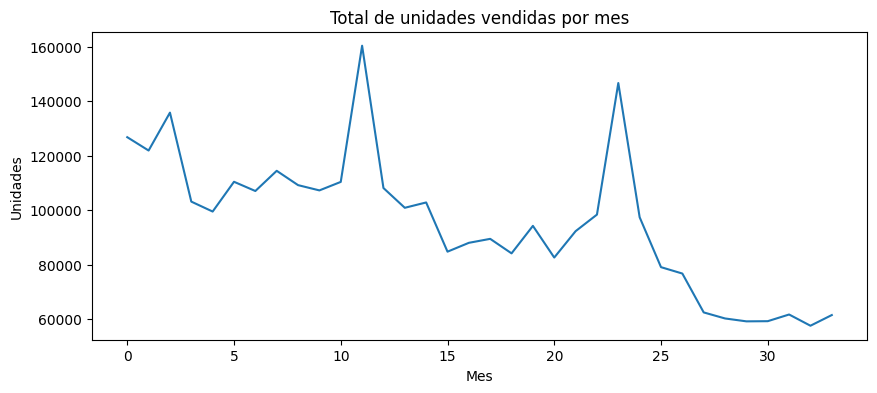

In [184]:
total_monthly = (monthly
                 .groupby('date_block_num', as_index = False)['item_cnt_month']
                 .sum()
                 .rename(columns = {'item_cnt_month': 'total_units'}))

plt.figure(figsize = (10,4))
plt.plot(total_monthly['date_block_num'], total_monthly['total_units'])
plt.title('Total de unidades vendidas por mes')
plt.xlabel('Mes')
plt.ylabel('Unidades')
plt.show()

In [185]:
#data.to_feather('data/clean_data.feather')

# Model

## Training

Selecionamos las variables:

In [186]:
descartar = ['shop_name', 'city', 'mall_name', 'type', 'item_category_name', 
             'category', 'platform', 'content', 'item_cnt_month']

In [ ]:
features = [
    # Pendientes
    # 'mall_name',

    # ids
    #'shop_id', 'item_id', 'item_category_id',

    # num
    #'avg_price',  'lag_1', 'lag_2', 'lag_3', 'lag_6', 'lag_12', 
    #'rolling_mean_3', 'rolling_mean_6', 'shop_month_mean', 'item_month_mean',
    #'shop_month_mean_lag_1', 'item_month_mean_lag_1',

    # temp
    #'month', 'date_block_num', 'is_q4', 'month_num', 'year',
    
    # cat
    #'city_Москва', 'city_Якутск', 'mall_name_Мега', 'type_ТРЦ', 'type_ТЦ', 
    #'category_Аксессуары', 'category_Игровые консоли', 'category_Игры', 
    #'category_Книги', 'category_Подарки', 'platform_1С', 'platform_OTHER', 
    #'platform_PC', 'platform_PSP', 'platform_XBOX', 'content_OTHER', 
    #'content_Цифра'

    # Estas
    #'month',
    #'shop_id', 'item_id', 'item_category_id', 'avg_price', 'lag_1', 'lag_2', 
    #'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6', 
    #'shop_month_mean', 'item_month_mean', 'shop_month_mean_lag_1', 
    #'item_month_mean_lag_1', 'date_block_num', 'is_q4', 'month_num', 
    #'n_items_shop', 'n_categories_shop', 'n_items_shop_lag1', 'n_categories_shop_lag1',
    
    #col for col in monthly.columns if col not in descartar

    #'item_month_mean', 'avg_price', 'item_id', 'shop_month_mean', 'lag_1', 'shop_id', 
    #'item_month_mean_lag_1', 'item_category_id', 'n_items_shop_lag1', 'date_block_num'
    
    'item_month_mean', 'item_id', 'avg_price', 'shop_month_mean', 'shop_id', 'lag_1', 
    'shop_month_mean_lag_1', 'n_items_shop_lag1', 'date_block_num', 'item_category_id', 
    'shop_month_mean_lag_1', 'n_items_shop'

]

X = monthly[features]
y = monthly['item_cnt_month']

Separamos nuestros datos en train y validation:

In [189]:
split_date = monthly['month'].max() - 3

X_train = X[monthly['month'] <= split_date].drop(columns = 'month')
y_train = y[monthly['month'] <= split_date]

X_valid = X[monthly['month'] > split_date].drop(columns = 'month')
y_valid = y[monthly['month'] > split_date]

In [190]:
monthly['month'].max(), split_date

(Period('2015-10', 'M'), Period('2015-07', 'M'))

## XGBoost

In [191]:
model = XGBRegressor(
    n_estimators = 800,
    learning_rate = 0.05,
    max_depth = 8,
    subsample = 0.8,
    colsample_bytree = 0.8,
    objective = 'reg:squarederror',
    random_state = 42
)

model.fit(
    X_train,
    y_train,
    eval_set = [(X_valid, y_valid)],
    verbose = 100
)

[0]	validation_0-rmse:2.32759
[100]	validation_0-rmse:1.26387
[200]	validation_0-rmse:1.23873
[300]	validation_0-rmse:1.23013
[400]	validation_0-rmse:1.22502
[500]	validation_0-rmse:1.22303
[600]	validation_0-rmse:1.22043
[700]	validation_0-rmse:1.21896
[799]	validation_0-rmse:1.21756


,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

## Evaluation

In [192]:
preds = model.predict(X_valid)
#preds = np.clip(preds, 0, 20)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
print('RMSE:', rmse)

RMSE: 1.2175643152206923


[0.00506124 0.00881661 0.0055312  0.01744732 0.00905925 0.01031629
 0.0088409  0.0051274  0.01021139 0.06287181 0.00952735 0.00527003
 0.00385036 0.00460216 0.01922197 0.01012968 0.02784703 0.30778918
 0.00623304 0.01687661 0.092695   0.01498337 0.04055869 0.00861316
 0.0166629  0.02010054 0.00856717 0.01205378 0.00855145 0.00347601
 0.00528241 0.03165428 0.02030883 0.01179538 0.05315898 0.03779957
 0.02116711 0.00575633 0.01046266 0.01315513 0.00856647]


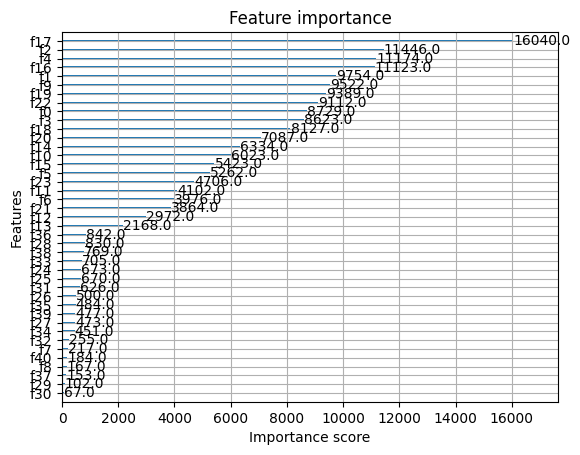

In [193]:
# feature importance
print(model.feature_importances_)
# plot
plot_importance(model)
plt.show()

In [195]:
X_train.columns[17], X_train.columns[2], X_train.columns[4], X_train.columns[16], X_train.columns[1], X_train.columns[9], X_train.columns[19], X_train.columns[22], X_train.columns[0], X_train.columns[3], X_train.columns[18], X_train.columns[20]

('item_month_mean',
 'item_id',
 'avg_price',
 'shop_month_mean',
 'shop_id',
 'lag_1',
 'item_month_mean_lag_1',
 'n_items_shop_lag1',
 'date_block_num',
 'item_category_id',
 'shop_month_mean_lag_1',
 'n_items_shop')

In [ ]:
X_train.columns

Index(['shop_id', 'item_id', 'item_category_id', 'avg_price', 'lag_1', 'lag_2',
       'lag_3', 'lag_6', 'lag_12', 'rolling_mean_3', 'rolling_mean_6',
       'shop_month_mean', 'item_month_mean', 'shop_month_mean_lag_1',
       'item_month_mean_lag_1', 'date_block_num', 'is_q4', 'month_num',
       'n_items_shop', 'n_categories_shop', 'n_items_shop_lag1',
       'n_categories_shop_lag1'],
      dtype='str')

In [ ]:
# predecir siempre 0
pred_zero = np.zeros(len(y_valid))
rmse_zero = np.sqrt(mean_squared_error(y_valid, pred_zero))

# predecir lo mismo que el mes pasado (lag_1)
pred_lag1 = X_valid['lag_1'].values
rmse_lag1 = np.sqrt(mean_squared_error(y_valid, pred_lag1))

print("RMSE baseline (siempre 0):", rmse_zero)
print("RMSE baseline (lag_1):", rmse_lag1)
print("RMSE XGBoost:", rmse)

RMSE baseline (siempre 0): 3.0655630399123153
RMSE baseline (lag_1): 2.46359201190873
RMSE XGBoost: 1.2326798156958725


## Ridge

In [ ]:
model = Ridge(
    alpha = 1.0
    )

model.fit(
    X_train,
    y_train
)

,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [ ]:
preds = model.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, preds))
print('RMSE:', rmse)

RMSE: 4.0499632632416676e-07


In [ ]:
# predecir siempre 0
pred_zero = np.zeros(len(y_valid))
rmse_zero = np.sqrt(mean_squared_error(y_valid, pred_zero))

# predecir lo mismo que el mes pasado (lag_1)
pred_lag1 = X_valid['lag_1'].values
rmse_lag1 = np.sqrt(mean_squared_error(y_valid, pred_lag1))

print("RMSE baseline (siempre 0):", rmse_zero)
print("RMSE baseline (lag_1):", rmse_lag1)
print("RMSE Ridge:", rmse)

RMSE baseline (siempre 0): 3.202425066639884
RMSE baseline (lag_1): 2.801545444457182
RMSE Ridge: 1.664354408512429


# Prediction

In [ ]:
test_df = pd.read_csv('data/test.csv')
test_df

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [ ]:
test_df = pd.merge(test_df, items, how = 'left', on = 'item_id')
test_df = pd.merge(test_df, categories, how = 'left', on = 'item_category_id')
test_df = pd.merge(test_df, shops, how = 'left', on = 'shop_id')
test_df

,ID,shop_id,item_id,item_name,item_category_id,item_category_name,shop_name
0,0,5,5037,"NHL 15 [PS3, русские субтитры]",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
1,1,5,5320,ONE DIRECTION Made In The A.M.,55,Музыка - CD локального производства,"Вологда ТРЦ ""Мармелад"""
2,2,5,5233,"Need for Speed Rivals (Essentials) [PS3, русск...",19,Игры - PS3,"Вологда ТРЦ ""Мармелад"""
3,3,5,5232,"Need for Speed Rivals (Classics) [Xbox 360, ру...",23,Игры - XBOX 360,"Вологда ТРЦ ""Мармелад"""
4,4,5,5268,"Need for Speed [PS4, русская версия]",20,Игры - PS4,"Вологда ТРЦ ""Мармелад"""
...,...,...,...,...,...,...,...
214195,214195,45,18454,СБ. Союз 55,55,Музыка - CD локального производства,"Самара ТЦ ""ПаркХаус"""
214196,214196,45,16188,Настольная игра Нано Кёрлинг,64,Подарки - Настольные игры,"Самара ТЦ ""ПаркХаус"""
214197,214197,45,15757,НОВИКОВ АЛЕКСАНДР Новая коллекция,55,Музыка - CD локального производства,"Самара ТЦ ""ПаркХаус"""
214198,214198,45,19648,ТЕРЕМ - ТЕРЕМОК сб.м/ф (Регион),40,Кино - DVD,"Самара ТЦ ""ПаркХаус"""


In [ ]:
last_date = monthly['month'].max()
last_date

Timestamp('2015-10-01 00:00:00')

In [ ]:
future_date = last_date + pd.offsets.MonthBegin(1)
future_date

Timestamp('2015-11-01 00:00:00')

In [ ]:
future_df = test_df[['ID', 'shop_id', 'item_id']].copy()
future_df['date'] = future_date
future_df['year'] = future_date.year
future_df['month'] = future_date.month

In [ ]:
last_month_data = monthly[
    monthly['month'] == last_date
][['shop_id', 'item_id', 'item_cnt_month']]

last_month_data = last_month_data.rename(
    columns={'item_cnt_month': 'lag_1'}
)

In [ ]:
last_month_data

,shop_id,item_id,lag_1
4,2,31,1.00000000
62,2,486,3.00000000
170,2,1075,1.00000000
175,2,1377,1.00000000
179,2,1387,1.00000000
...,...,...,...
907087,59,21427,1.00000000
907429,59,22087,6.00000000
907459,59,22088,2.00000000
907474,59,22091,1.00000000


In [ ]:
future_df = future_df.merge(
    last_month_data,
    on=['shop_id', 'item_id'],
    how='left'
)
future_df

,ID,shop_id,item_id,date,year,month,lag_1
0,0,5,5037,2015-11-01,2015,11,NaN
1,1,5,5320,2015-11-01,2015,11,NaN
2,2,5,5233,2015-11-01,2015,11,1.00000000
3,3,5,5232,2015-11-01,2015,11,NaN
4,4,5,5268,2015-11-01,2015,11,NaN
...,...,...,...,...,...,...,...
214195,214195,45,18454,2015-11-01,2015,11,1.00000000
214196,214196,45,16188,2015-11-01,2015,11,NaN
214197,214197,45,15757,2015-11-01,2015,11,NaN
214198,214198,45,19648,2015-11-01,2015,11,NaN


In [ ]:
lag_2_date = last_date - pd.offsets.MonthBegin(1)

lag_2_data = monthly[
    monthly['month'] == lag_2_date
][['shop_id', 'item_id', 'item_cnt_month']]

lag_2_data = lag_2_data.rename(
    columns={'item_cnt_month': 'lag_2'}
)

In [ ]:
future_df = future_df.merge(
    lag_2_data,
    on=['shop_id', 'item_id'],
    how='left'
)

In [ ]:
future_df

,ID,shop_id,item_id,date,year,month,lag_1,lag_2
0,0,5,5037,2015-11-01,2015,11,NaN,1.00000000
1,1,5,5320,2015-11-01,2015,11,NaN,NaN
2,2,5,5233,2015-11-01,2015,11,1.00000000,3.00000000
3,3,5,5232,2015-11-01,2015,11,NaN,NaN
4,4,5,5268,2015-11-01,2015,11,NaN,NaN
...,...,...,...,...,...,...,...,...
214195,214195,45,18454,2015-11-01,2015,11,1.00000000,NaN
214196,214196,45,16188,2015-11-01,2015,11,NaN,NaN
214197,214197,45,15757,2015-11-01,2015,11,NaN,NaN
214198,214198,45,19648,2015-11-01,2015,11,NaN,NaN


In [ ]:
future_df['lag_1'] = future_df['lag_1'].fillna(0)
future_df['lag_2'] = future_df['lag_2'].fillna(0)

In [ ]:
avg_price_item = (
    data
    .groupby('item_id')['item_price']
    .mean()
    .reset_index(name='avg_price')
)

future_df = future_df.merge(
    avg_price_item,
    on='item_id',
    how='left'
)

In [ ]:
features = [
    'shop_id',
    'item_id',
    'year',
    'avg_price',
    'month',
    'lag_1',
    'lag_2'
]

X_future = future_df[features]

In [ ]:
future_df['item_cnt_month'] = model.predict(X_future)

future_df['item_cnt_month'] = (
    future_df['item_cnt_month']
    .clip(0)
    .round()
)

In [ ]:
future_df

,ID,shop_id,item_id,date,year,month,lag_1,lag_2,avg_price,item_cnt_month
0,0,5,5037,2015-11-01,2015,11,0.00000000,1.00000000,1926.82838843,2.00000000
1,1,5,5320,2015-11-01,2015,11,0.00000000,0.00000000,NaN,2.00000000
2,2,5,5233,2015-11-01,2015,11,1.00000000,3.00000000,800.77750000,2.00000000
3,3,5,5232,2015-11-01,2015,11,0.00000000,0.00000000,790.51292308,2.00000000
4,4,5,5268,2015-11-01,2015,11,0.00000000,0.00000000,NaN,2.00000000
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,2015-11-01,2015,11,1.00000000,0.00000000,188.68108384,2.00000000
214196,214196,45,16188,2015-11-01,2015,11,0.00000000,0.00000000,1256.97500000,2.00000000
214197,214197,45,15757,2015-11-01,2015,11,0.00000000,0.00000000,198.11320755,2.00000000
214198,214198,45,19648,2015-11-01,2015,11,0.00000000,0.00000000,98.09629630,2.00000000


In [ ]:
X_future

,shop_id,item_id,year,avg_price,month,lag_1,lag_2
0,5,5037,2015,1926.82838843,11,0.00000000,1.00000000
1,5,5320,2015,NaN,11,0.00000000,0.00000000
2,5,5233,2015,800.77750000,11,1.00000000,3.00000000
3,5,5232,2015,790.51292308,11,0.00000000,0.00000000
4,5,5268,2015,NaN,11,0.00000000,0.00000000
...,...,...,...,...,...,...,...
214195,45,18454,2015,188.68108384,11,1.00000000,0.00000000
214196,45,16188,2015,1256.97500000,11,0.00000000,0.00000000
214197,45,15757,2015,198.11320755,11,0.00000000,0.00000000
214198,45,19648,2015,98.09629630,11,0.00000000,0.00000000


In [ ]:
future_df['item_cnt_month'] = model.predict(X_future)

In [ ]:
future_df['item_cnt_month'] = (
    future_df['item_cnt_month']
    .clip(0)
    .round()
)

In [ ]:
future_df

,ID,shop_id,item_id,date,year,month,lag_1,lag_2,avg_price,item_cnt_month
0,0,5,5037,2015-11-01,2015,11,0.00000000,1.00000000,1926.82838843,2.00000000
1,1,5,5320,2015-11-01,2015,11,0.00000000,0.00000000,NaN,2.00000000
2,2,5,5233,2015-11-01,2015,11,1.00000000,3.00000000,800.77750000,2.00000000
3,3,5,5232,2015-11-01,2015,11,0.00000000,0.00000000,790.51292308,2.00000000
4,4,5,5268,2015-11-01,2015,11,0.00000000,0.00000000,NaN,2.00000000
...,...,...,...,...,...,...,...,...,...,...
214195,214195,45,18454,2015-11-01,2015,11,1.00000000,0.00000000,188.68108384,2.00000000
214196,214196,45,16188,2015-11-01,2015,11,0.00000000,0.00000000,1256.97500000,2.00000000
214197,214197,45,15757,2015-11-01,2015,11,0.00000000,0.00000000,198.11320755,2.00000000
214198,214198,45,19648,2015-11-01,2015,11,0.00000000,0.00000000,98.09629630,2.00000000


In [ ]:
future_df.describe()

,ID,shop_id,item_id,date,year,month,lag_1,lag_2,avg_price,item_cnt_month
count,214200.00000000,214200.00000000,214200.00000000,214200,214200.00000000,214200.00000000,214200.00000000,214200.00000000,198954.00000000,214200.00000000
mean,107099.50000000,31.64285714,11019.39862745,2015-11-01 00:00:00,2015.00000000,11.00000000,0.18077498,0.18071895,1026.49518258,2.02668524
min,0.00000000,2.00000000,30.00000000,2015-11-01 00:00:00,2015.00000000,11.00000000,-1.00000000,-1.00000000,4.91485570,0.00000000
25%,53549.75000000,16.00000000,5381.50000000,2015-11-01 00:00:00,2015.00000000,11.00000000,0.00000000,0.00000000,284.33909341,2.00000000
50%,107099.50000000,34.50000000,11203.00000000,2015-11-01 00:00:00,2015.00000000,11.00000000,0.00000000,0.00000000,490.53697183,2.00000000
75%,160649.25000000,47.00000000,16071.50000000,2015-11-01 00:00:00,2015.00000000,11.00000000,0.00000000,0.00000000,1246.20808343,2.00000000
max,214199.00000000,59.00000000,22167.00000000,2015-11-01 00:00:00,2015.00000000,11.00000000,500.00000000,473.00000000,39990.50000000,178.00000000
std,61834.35816761,17.56193349,6252.64458994,NaN,0.00000000,0.00000000,2.41916550,2.20080540,1969.09315786,1.24762154


In [ ]:
future_df[['ID', 'item_cnt_month']].to_csv('data/prediction.csv')